
Available CSV files:
1. AABA_2006-01-01_to_2018-01-01.csv
2. AAPL_2006-01-01_to_2018-01-01.csv
3. all_stocks_2006-01-01_to_2018-01-01.csv
4. all_stocks_2017-01-01_to_2018-01-01.csv
5. AMZN_2006-01-01_to_2018-01-01.csv
6. AXP_2006-01-01_to_2018-01-01.csv
7. BA_2006-01-01_to_2018-01-01.csv
8. CAT_2006-01-01_to_2018-01-01.csv
9. CSCO_2006-01-01_to_2018-01-01.csv
10. CVX_2006-01-01_to_2018-01-01.csv
11. DIS_2006-01-01_to_2018-01-01.csv
12. GE_2006-01-01_to_2018-01-01.csv
13. GOOGL_2006-01-01_to_2018-01-01.csv
14. GS_2006-01-01_to_2018-01-01.csv
15. HD_2006-01-01_to_2018-01-01.csv
16. IBM_2006-01-01_to_2018-01-01.csv
17. INTC_2006-01-01_to_2018-01-01.csv
18. JNJ_2006-01-01_to_2018-01-01.csv
19. JPM_2006-01-01_to_2018-01-01.csv
20. KO_2006-01-01_to_2018-01-01.csv
21. MCD_2006-01-01_to_2018-01-01.csv
22. MMM_2006-01-01_to_2018-01-01.csv
23. MRK_2006-01-01_to_2018-01-01.csv
24. MSFT_2006-01-01_to_2018-01-01.csv
25. NKE_2006-01-01_to_2018-01-01.csv
26. PFE_2006-01-01_to_2018-01-01.csv
27. PG_2


Enter the number of the CSV file you want to load (e.g., 1, 2, ...):  `16


Please enter a valid number



Enter the number of the CSV file you want to load (e.g., 1, 2, ...):  1



Selected CSV file: C:\Users\Yash\Downloads\extracted_data\AABA_2006-01-01_to_2018-01-01.csv
Loaded AABA_2006-01-01_to_2018-01-01 dataset.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Isolation Forest - Precision: 0.05, Recall: 0.05
Autoencoder - Precision: 0.05, Recall: 0.05


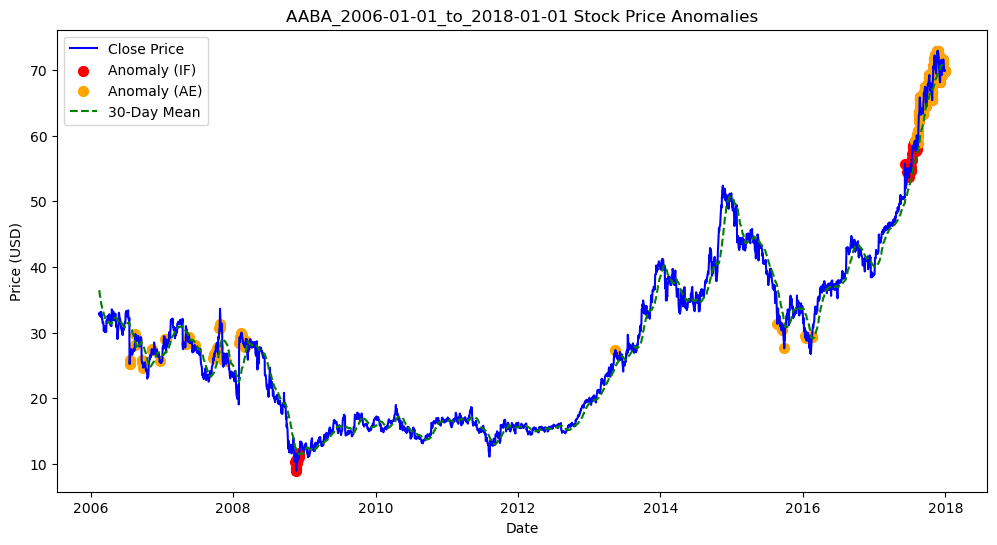

Results saved to 'AABA_2006-01-01_to_2018-01-01_results.csv'
Anomalies detected - IF: 150, AE: 150


In [30]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Extract and Load Dataset
zip_path = r"C:\Users\Yash\Downloads\archive.zip"
extract_dir = os.path.join(os.path.dirname(zip_path), "extracted_data")

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_files = [os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith('.csv')]
if not csv_files:
    print("No CSV files found.")
    exit()

print("\nAvailable CSV files:")
for i, csv_file in enumerate(csv_files, 1):
    print(f"{i}. {os.path.basename(csv_file)}")

while True:
    try:
        choice = int(input("\nEnter the number of the CSV file you want to load (e.g., 1, 2, ...): "))
        if 1 <= choice <= len(csv_files):
            selected_csv = csv_files[choice - 1]
            break
        else:
            print(f"Please enter a number between 1 and {len(csv_files)}")
    except ValueError:
        print("Please enter a valid number")

print(f"\nSelected CSV file: {selected_csv}")

df = pd.read_csv(selected_csv)
stock_name = os.path.basename(selected_csv).split('.')[0]
print(f"Loaded {stock_name} dataset.")

# Preprocess Data
date_col = next(col for col in df.columns if 'date' in col.lower())
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)
data = df[['Close']].copy()
data['Rolling_Mean'] = data['Close'].rolling(window=30).mean()
data.dropna(inplace=True)

# Isolation Forest Anomaly Detection
X = data[['Close', 'Rolling_Mean']]
model_if = IsolationForest(contamination=0.05, random_state=42, n_estimators=200) 
data['Anomaly_IF'] = model_if.fit_predict(X) == -1

# Autoencoder Anomaly Detection
X_tf = X.values
X_tf_norm = (X_tf - X_tf.mean(axis=0)) / X_tf.std(axis=0)
autoencoder = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(32, activation='relu'), 
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_tf_norm, X_tf_norm, epochs=100, batch_size=16, validation_split=0.2, verbose=0)
reconstructions = autoencoder.predict(X_tf_norm)
mse = np.mean((X_tf_norm - reconstructions) ** 2, axis=1)
data['Anomaly_TF'] = mse > np.percentile(mse, 95) 

# Accuracy Test with Synthetic Ground Truth
np.random.seed(42)
true_anomalies = np.random.choice([True, False], size=len(data), p=[0.05, 0.95])
data['True_Anomaly'] = true_anomalies

# Calculate precision and recall
prec_if = precision_score(data['True_Anomaly'], data['Anomaly_IF'])
rec_if = recall_score(data['True_Anomaly'], data['Anomaly_IF'])
prec_tf = precision_score(data['True_Anomaly'], data['Anomaly_TF'])
rec_tf = recall_score(data['True_Anomaly'], data['Anomaly_TF'])

print(f"Isolation Forest - Precision: {prec_if:.2f}, Recall: {rec_if:.2f}")
print(f"Autoencoder - Precision: {prec_tf:.2f}, Recall: {rec_tf:.2f}")

# Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.scatter(data.index[data['Anomaly_IF']], data['Close'][data['Anomaly_IF']], 
            color='red', label='Anomaly (IF)', s=50)
plt.scatter(data.index[data['Anomaly_TF']], data['Close'][data['Anomaly_TF']], 
            color='orange', label='Anomaly (AE)', s=50)
plt.plot(data.index, data['Rolling_Mean'], label='30-Day Mean', color='green', linestyle='--')
plt.title(f'{stock_name} Stock Price Anomalies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Save Results
data.to_csv(f'{stock_name}_results.csv')
print(f"Results saved to '{stock_name}_results.csv'")
print(f"Anomalies detected - IF: {data['Anomaly_IF'].sum()}, AE: {data['Anomaly_TF'].sum()}")